# Notebook 2b: Reading and plotting radial profiles

Here we load the data produced in notebook 2a and plot it (so you'll need to run that notebook first!)

The main goal of this notebook is to show how one can load previously saved data including units and metadata
using the `PaicosReader` class.

In [1]:
import paicos as pa
import numpy as np

# Simply read the radial file using the standard reader
pro_simple = pa.PaicosReader(pa.root_dir + 'data', 247,
                             basename='radial', load_all=True)

In [2]:
# The data fields that have been loaded
pro_simple.keys()

dict_keys(['0_MagneticFieldSquaredTimesVolume', '0_Masses', '0_PressureTimesVolume', '0_TemperaturesTimesMasses', '0_Volume', '1_Masses', '2_Masses', '3_Masses', '4_Masses', '5_Masses', 'Group', 'R200c', 'bin_centers', 'bin_volumes', 'center'])

In [3]:
# They all have units, for instance
pro_simple['0_PressureTimesVolume'][1].to('erg')

<PaicosQuantity 1.68020224e+61 erg / small_h>

The PaicosReader object has many of the same attributes as an instance of the Snaphot class (see notebook 1), e.g.
you can access

In [4]:
#pro_simple.Config
#pro_simple.Header
pro_simple.age

<PaicosQuantity 13.80223476 Gyr>

This is because the Snapshot class is a subclass of the PaicosReader class. 

## Define a custom reader

The default reader is already quite useful. It can however also be useful to define custom readers as done below.

In [5]:
class RadialReader(pa.PaicosReader):
    """
    A quick custom reader for radial profiles.
    This reader gets the densities and the weighted variables of interest
    """
    def __init__(self, basedir, snapnum, basename="radial", load_all=True):

        # The PaicosReader class takes care of most of the loading
        super().__init__(basedir, snapnum, basename=basename,
                         load_all=load_all)

        # Get the interesting profiles
        keys = list(self.keys())

        for key in keys:
            if 'Times' in key:
                # Keys of the form 'MagneticFieldSquaredTimesVolume'
                # are split up
                start, end = key.split('Times')
                if (end in keys):
                    self[start] = self[key]/self[end]
                    del self[key]
                elif (start[0:2] + end in keys):
                    self[start] = self[key]/self[start[0:2] + end]
                    del self[key]

        # Calculate density if we have both masses and volumes
        for p in ['', '0_']:
            if (p + 'Masses' in keys) and (p + 'Volume' in keys):
                self[p + 'Density'] = self[p+'Masses']/self[p+'Volume']

        # For dark matter we use the bin volumes
        for p in [str(i) + '_' for i in range(1, 5)]:
            self[p + 'Density'] = self[p+'Masses']/self['bin_volumes']
            del self[p+'Masses']


pro = RadialReader(pa.root_dir + 'data', 247)

In [6]:
# The data fields now contain the following fields
pro.keys()

dict_keys(['0_Masses', '0_Volume', '5_Masses', 'Group', 'R200c', 'bin_centers', 'bin_volumes', 'center', '0_MagneticFieldSquared', '0_Pressure', '0_Temperatures', '0_Density', '1_Density', '2_Density', '3_Density', '4_Density'])

## Plotting the radial profiles

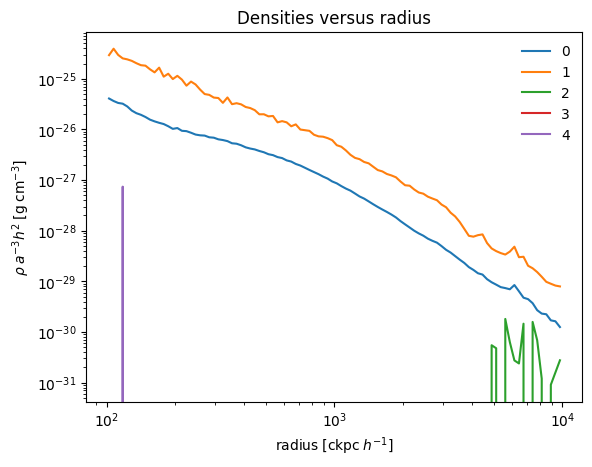

In [7]:
# Make a density plot of the varius particle types
import matplotlib.pyplot as plt
for p in range(5):
    pstr = str(p)
    plt.loglog(pro['bin_centers'].astro, pro[pstr + '_Density'].cgs, label=pstr)

plt.xlabel(pro['bin_centers'].astro.label(r'\mathrm{radius}'))
plt.ylabel(pro['0_Density'].cgs.label(r'\rho'))
plt.title('Densities versus radius')
plt.legend(frameon=False)

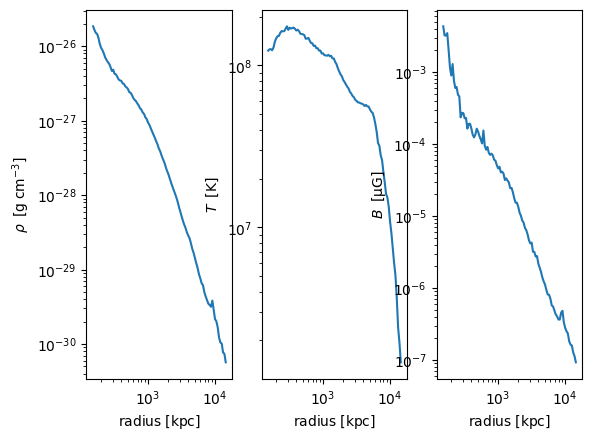

In [8]:
# Plot gas properties
fig, axes = plt.subplots(num=2, ncols=3, sharex=True)
centers = pro['bin_centers'].astro.to_physical
rho = pro['0_Density'].cgs.to_physical
axes[0].loglog(centers, rho)
axes[0].set_ylabel(rho.label("\\rho"))

axes[1].loglog(centers, pro['0_Temperatures'])
axes[1].set_ylabel(pro['0_Temperatures'].label("T"))

B = np.sqrt(pro['0_MagneticFieldSquared']).to('uG').to_physical
axes[2].loglog(centers, B)
axes[2].set_ylabel(B.label("B"))

for ii in range(3):
    axes[ii].set_xlabel(centers.label(r'\mathrm{radius}'))

## Plot group properties

Text(0, 0.5, '$M_{200\\mathrm{c}}\\;\\; \\left[\\mathrm{M_{\\odot}}\\right]$')

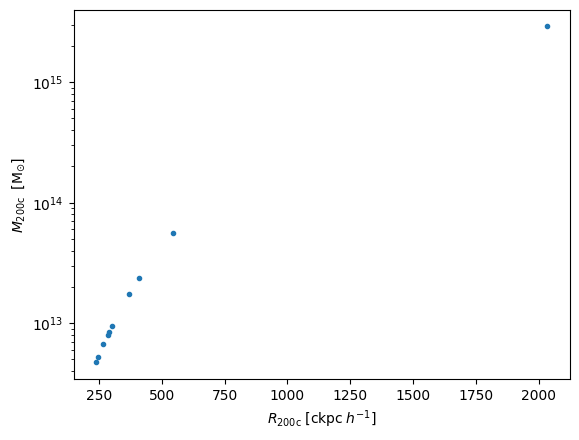

In [9]:
# Plot halo masses versus radii
R = pro['Group']['Group_R_Crit200'].astro
M = pro['Group']['Group_M_Crit200'].no_small_h.astro
plt.semilogy(R, M, '.')
plt.xlabel(R.label(r'R_{200\mathrm{c}}'))
plt.ylabel(M.label(r'M_{200\mathrm{c}}'))